<a href="https://colab.research.google.com/github/kenwilliford/ML_miscellany/blob/main/encoder_models_transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning for Text - Encoder Models

## Data Preprocessing



Let's begin extracting the data from the ATIS dataset and turning into a form that we can use in our Deep Learning models.

The ATIS dataset is standard benchmark dataset widely used to build models for intent classification and slot filling tasks. See detailed explanation [here](https://catalog.ldc.upenn.edu/docs/LDC93S4B/corpus.html).

We will begin by loading the file and then partitioning into a test and a training set.

In [1]:
import pandas as pd
import numpy as np
import pickle
import os
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

from google.colab import drive

keras.utils.set_random_seed(42)

In [3]:
drive.mount('/content/drive')
df_train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Module_21/atis_train_data.csv')
df_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Module_21/atis_test_data.csv')

Mounted at /content/drive


Let's visualize all of this on a dataframe. Below we display an example query for each intent class in a nice layout.

The first column of the Dataframe below contains the actual query that was asked. The second column indicates the intent (flight, flight time, etc), whereas the last column contains the slot filling structure.

In [27]:
pd.set_option('display.max_colwidth', None)
df_small = pd.DataFrame(columns=['query','intent','slot filling'])
j = 0
for i in df_train.intent.unique():
  df_small.loc[j] = df_train[df_train.intent==i].iloc[0]
  j = j+1

df_small

,query,intent,slot filling
0,i want to fly from boston at 838 am and arrive in denver at 1110 in the morning,flight,O O O O O B-fromloc.city_name O B-depart_time.time I-depart_time.time O O O B-toloc.city_name O B-arrive_time.time O O B-arrive_time.period_of_day
1,what is the arrival time in san francisco for the 755 am flight leaving washington,flight_time,O O O B-flight_time I-flight_time O B-fromloc.city_name I-fromloc.city_name O O B-depart_time.time I-depart_time.time O O B-fromloc.city_name
2,cheapest airfare from tacoma to orlando,airfare,B-cost_relative O O B-fromloc.city_name O B-toloc.city_name
3,what kind of aircraft is used on a flight from cleveland to dallas,aircraft,O O O O O O O O O O B-fromloc.city_name O B-toloc.city_name
4,what kind of ground transportation is available in denver,ground_service,O O O O O O O O B-city_name
5,what 's the airport at orlando,airport,O O O O O B-city_name
6,which airline serves denver pittsburgh and atlanta,airline,O O O B-fromloc.city_name B-fromloc.city_name O B-fromloc.city_name
7,how far is it from orlando airport to orlando,distance,O O O O O B-fromloc.airport_name I-fromloc.airport_name O B-toloc.city_name
8,what is fare code h,abbreviation,O O O O B-fare_basis_code
9,how much does the limousine service cost within pittsburgh,ground_fare,O O O O B-transport_type O O O B-city_name


Let's see how many different types of "intent" are present in the data.

In [5]:
df_train['intent'].value_counts()

flight                        3666
airfare                       423 
ground_service                255 
airline                       157 
abbreviation                  147 
aircraft                      81  
flight_time                   54  
quantity                      51  
flight+airfare                21  
airport                       20  
distance                      20  
city                          19  
ground_fare                   18  
capacity                      16  
flight_no                     12  
meal                          6   
restriction                   6   
airline+flight_no             2   
ground_service+ground_fare    1   
airfare+flight_time           1   
cheapest                      1   
aircraft+flight+flight_no     1   
Name: intent, dtype: int64

In [6]:
query_data_train = df_train['query'].values
intent_data_train = df_train['intent'].values
slot_data_train = df_train['slot filling'].values

query_data_test = df_test['query'].values
intent_data_test = df_test['intent'].values
slot_data_test = df_test['slot filling'].values

Let's explore the difference between slot filling and intent...

As an example, let’s consider the user query “*i want to fly from boston at 838 am and arrive in denver at 1110 in the morning*”. The model should classify this user query as “**flight**” intent. It should also parse the query, identify and fill all slots necessary for understanding the query. Although the words “I”, “want”, “to”, “fly”, “from”, “at”, “and”, “arrive”, “in”, “the” contribute to understand the context of the intent, the model should correctly label the entities needed to fulfill user’s goal in its intention to take a flight. These are “boston” as departure city (B-fromloc.city), “8:38 am” as departure time (B-depart_time.time), “denver” as destination city (B-toloc.city_name), “11:10” as arrival time (B-arrive_time.time) and “morning” as arrival period of day (B-arrive_time.period_of_day). The 123 slot categories are shown below.

In [7]:
unique_slots = set()
for s in slot_data_train:
  unique_slots = unique_slots.union(set(s.split()))
unique_slots

{'B-aircraft_code',
 'B-airline_code',
 'B-airline_name',
 'B-airport_code',
 'B-airport_name',
 'B-arrive_date.date_relative',
 'B-arrive_date.day_name',
 'B-arrive_date.day_number',
 'B-arrive_date.month_name',
 'B-arrive_date.today_relative',
 'B-arrive_time.end_time',
 'B-arrive_time.period_mod',
 'B-arrive_time.period_of_day',
 'B-arrive_time.start_time',
 'B-arrive_time.time',
 'B-arrive_time.time_relative',
 'B-city_name',
 'B-class_type',
 'B-connect',
 'B-cost_relative',
 'B-day_name',
 'B-day_number',
 'B-days_code',
 'B-depart_date.date_relative',
 'B-depart_date.day_name',
 'B-depart_date.day_number',
 'B-depart_date.month_name',
 'B-depart_date.today_relative',
 'B-depart_date.year',
 'B-depart_time.end_time',
 'B-depart_time.period_mod',
 'B-depart_time.period_of_day',
 'B-depart_time.start_time',
 'B-depart_time.time',
 'B-depart_time.time_relative',
 'B-economy',
 'B-fare_amount',
 'B-fare_basis_code',
 'B-flight_days',
 'B-flight_mod',
 'B-flight_number',
 'B-flight_st

In [8]:
len(unique_slots)

123

**123 slot categories!!**

## Transformers





### On the attention mechanism...




As you’re going through a book, you may be skimming some parts and attentively reading others, depending on what your goals or interests are. What if your models did the same? It’s a simple yet powerful idea: not all input information seen by a model is equally important to the task at hand, so models should “pay more attention” to some features and “pay less attention” to other features.

Does that sound familiar? You’ve already encountered a similar concept twice in this book:

- Max pooling in convnets looks at a pool of features in a spatial region and selects just one feature to keep. That’s an “all or nothing” form of attention: keep the most important feature and discard the rest.
- TF-IDF normalization assigns importance scores to tokens based on how much information different tokens are likely to carry. Important tokens get boosted while irrelevant tokens get faded out. That’s a continuous form of attention.

There are many different forms of attention you could imagine, but they all start by computing importance scores for a set of features, with higher scores for more relevant features and lower scores for less relevant ones. How these scores should be computed, and what you should do with them, will vary from approach to approach.


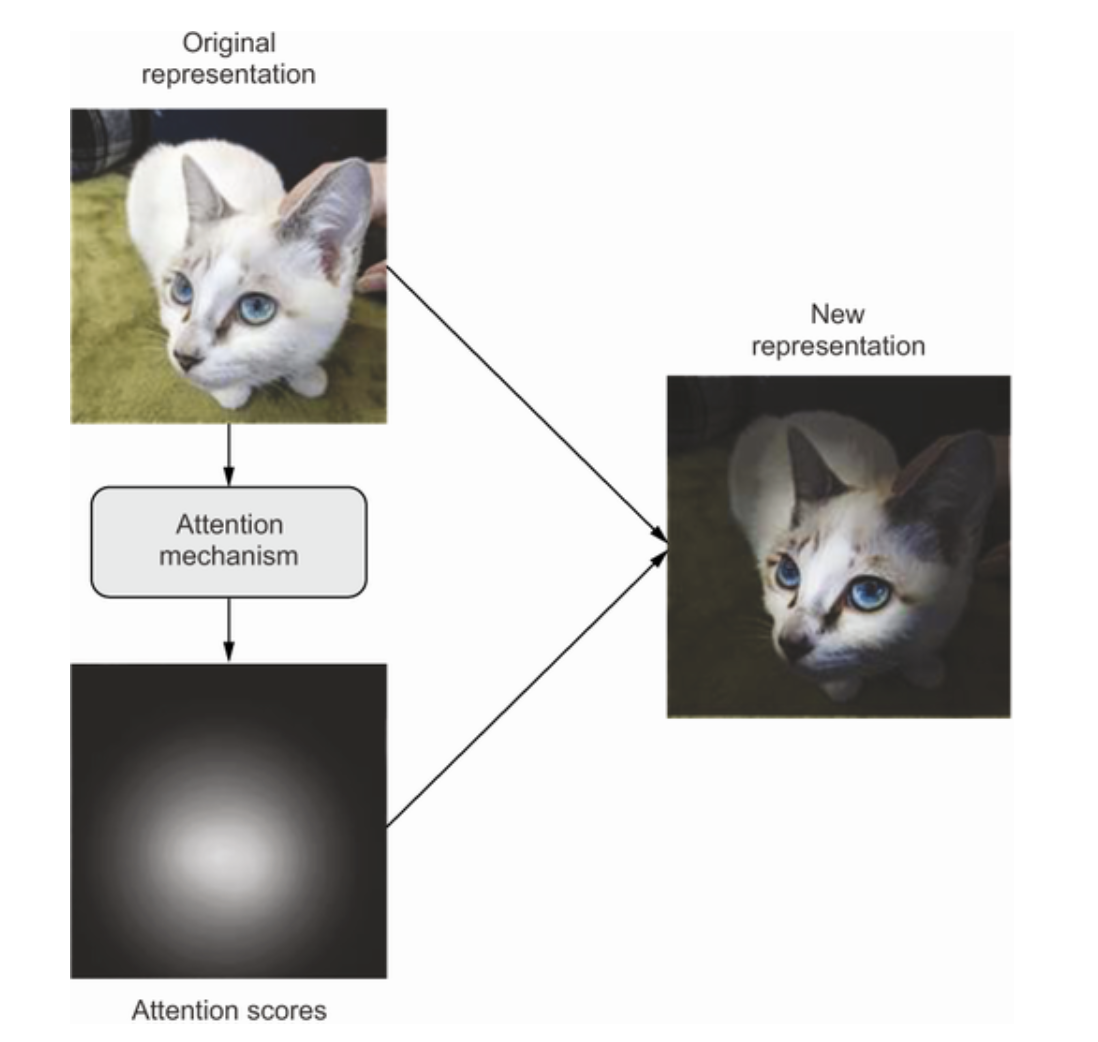

Crucially, this kind of attention mechanism can be used for more than just highlighting or erasing certain features. It can be used to make features context-aware. We've learned about word embeddings—vector spaces that capture the “shape” of the semantic relationships between different words. In an embedding space, a single word has a fixed position—a fixed set of relationships with every other word in the space. But that’s not quite how language works: the meaning of a word is usually context-specific. When you mark the date, you’re not talking about the same “date” as when you go on a date, nor is it the kind of date you’d buy at the market. When you say, “I’ll see you soon,” the meaning of the word “see” is subtly different from the “see” in “I’ll see this project to its end” or “I see what you mean.” And, of course, the meaning of pronouns like “he,” “it,” “in,” etc., is entirely sentence-specific and can even change multiple times within a single sentence.

Clearly, a smart embedding space would provide a different vector representation for a word depending on the other words surrounding it. That’s where self-attention comes in. The purpose of self-attention is to modulate the representation of a token by using the representations of related tokens in the sequence. This produces context-aware token representations. Consider an example sentence: “The train left the station on time.” Now, consider one word in the sentence: station. What kind of station are we talking about? Could it be a radio station? Maybe the International Space Station? Let’s figure it out algorithmically via self-attention.


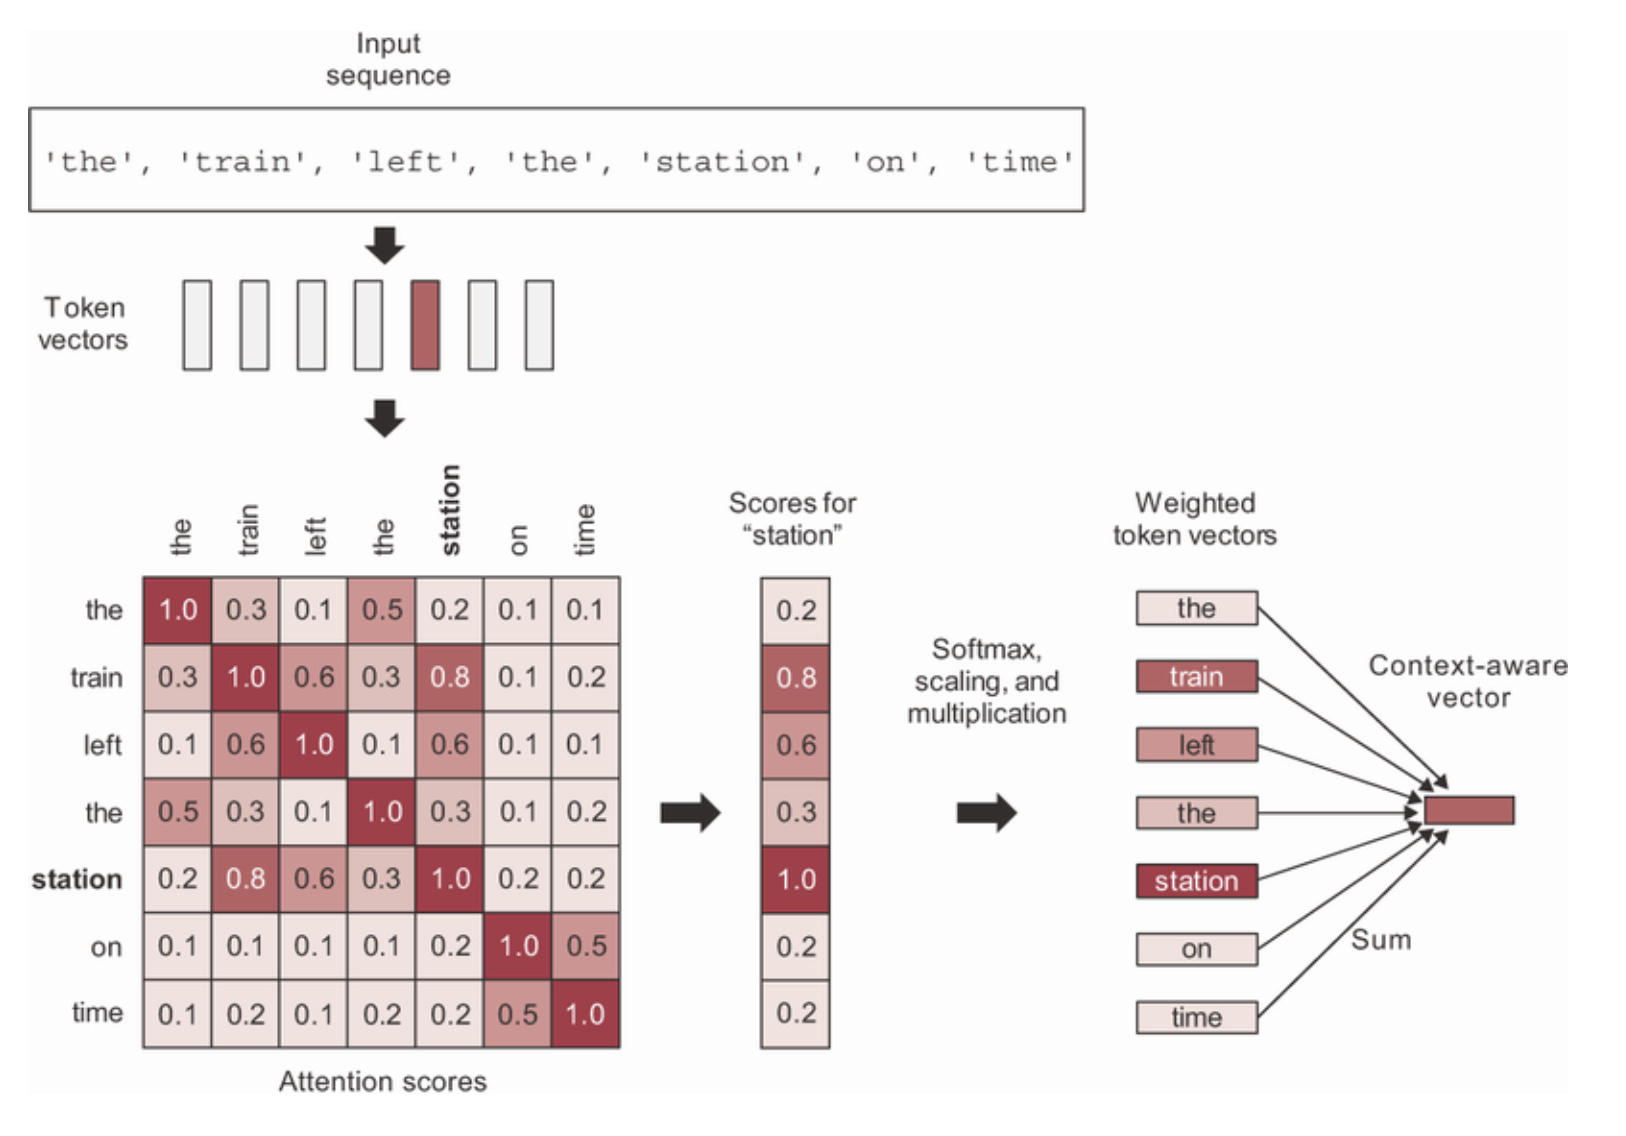



Step 1 is to compute relevancy scores between the vector for “station” and every other word in the sentence. These are our “attention scores.” We’re simply going to use the dot product between two word vectors as a measure of the strength of their relationship. It’s a very computationally efficient distance function, and it was already the standard way to relate two word embeddings to each other long before Transformers. In practice, these scores will also go through a scaling function and a softmax, but for now, that’s just an implementation detail.

Step 2 is to compute the sum of all word vectors in the sentence, weighted by our relevancy scores. Words closely related to “station” will contribute more to the sum (including the word “station” itself), while irrelevant words will contribute almost nothing. The resulting vector is our new representation for “station”: a representation that incorporates the surrounding context. In particular, it includes part of the “train” vector, clarifying that it is, in fact, a “train station.”

You’d repeat this process for every word in the sentence, producing a new sequence of vectors encoding the sentence.

### Encoder Model



Because the code for transformer encoder architecture is a bit complicated to write, we have decided to package it. This means that you can import it directly from our own "library" (in the same way you do it for Keras layers).


In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
# Download the "HODL" library
!wget -q '/content/drive/MyDrive/Colab Notebooks/Module_21/HODL.py'

In [11]:
import os

# Change to the directory containing HODL.py
os.chdir('/content/drive/MyDrive/Colab Notebooks/Module_21')


In [12]:
#import sys
#sys.path.append('/content/drive/MyDrive/Colab Notebooks/Module_21')
import HODL
from HODL import TransformerEncoder, PositionalEmbedding

In [13]:
import os

# Print the current working directory
print("Current Working Directory: ", os.getcwd())

# List files in the current working directory
print("Files in the Current Directory: ", os.listdir())


Current Working Directory:  /content/drive/MyDrive/Colab Notebooks/Module_21
Files in the Current Directory:  ['atis_test_data.csv', 'HODL.py', 'atis_train_data.csv', '__pycache__', 'Module_21_Video_2.ipynb', 'Module21_Video_1.ipynb']


In [14]:
query_data_train[:5]

array([' i want to fly from boston at 838 am and arrive in denver at 1110 in the morning ',
       ' what flights are available from pittsburgh to baltimore on thursday morning ',
       ' what is the arrival time in san francisco for the 755 am flight leaving washington ',
       ' cheapest airfare from tacoma to orlando ',
       ' round trip fares from pittsburgh to philadelphia under 1000 dollars '],
      dtype=object)

In [15]:
slot_data_train[:5]

array([' O O O O O B-fromloc.city_name O B-depart_time.time I-depart_time.time O O O B-toloc.city_name O B-arrive_time.time O O B-arrive_time.period_of_day ',
       ' O O O O O B-fromloc.city_name O B-toloc.city_name O B-depart_date.day_name B-depart_time.period_of_day ',
       ' O O O B-flight_time I-flight_time O B-fromloc.city_name I-fromloc.city_name O O B-depart_time.time I-depart_time.time O O B-fromloc.city_name ',
       ' B-cost_relative O O B-fromloc.city_name O B-toloc.city_name ',
       ' B-round_trip I-round_trip O O B-fromloc.city_name O B-toloc.city_name B-cost_relative B-fare_amount I-fare_amount '],
      dtype=object)

In [16]:
max_query_length = 30

'''
Setting standardize=None means that no standardization is applied
to the slot labels. Standardization is a preprocessing step that is
used to transform the data to have zero mean and unit variance.
However, slot labels are categorical variables and it doesn't make
sense to standardize them. Therefore, setting standardize=None is
appropriate in this case and ensures that the slot labels are encoded
as integer values without any normalization
'''

# Textvec of slots
text_vectorization_slots = keras.layers.TextVectorization(
    output_sequence_length=max_query_length,
    standardize=None
)
text_vectorization_slots.adapt(slot_data_train)

#Number of slots
slot_vocab_size = text_vectorization_slots.vocabulary_size()

target_train = text_vectorization_slots(slot_data_train)
target_test = text_vectorization_slots(slot_data_test)

# Textvec of query
text_vectorization_query = keras.layers.TextVectorization(
    output_sequence_length=max_query_length
)
text_vectorization_query.adapt(query_data_train)

#Numbr of unique query words
query_vocab_size = text_vectorization_query.vocabulary_size()

source_train = text_vectorization_query(query_data_train)
source_test = text_vectorization_query(query_data_test)

In [17]:
# Params
embedding_dim = 512
encoder_units = 64
units = 128
num_heads = 5

# Embedding and Masking
inputs = keras.Input(shape=(max_query_length,))
embedding = PositionalEmbedding(max_query_length, query_vocab_size, embedding_dim)
x = embedding(inputs)

# Transformer Encoding
encoder_out = TransformerEncoder(embedding_dim, encoder_units, num_heads)(x)

# Classifier
x = keras.layers.Dense(units, activation='relu')(encoder_out)
x = keras.layers.Dropout(0.5)(x)
outputs = keras.layers.Dense(slot_vocab_size, activation="softmax")(x)

model = keras.Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 30)]              0         
                                                                 
 positional_embedding (Posi  (None, 30, 512)           470016    
 tionalEmbedding)                                                
                                                                 
 transformer_encoder (Trans  (None, 30, 512)           5319232   
 formerEncoder)                                                  
                                                                 
 dense_2 (Dense)             (None, 30, 128)           65664     
                                                                 
 dropout (Dropout)           (None, 30, 128)           0         
                                                                 
 dense_3 (Dense)             (None, 30, 125)           16125 

In [18]:
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["sparse_categorical_accuracy"])


In [19]:
BATCH_SIZE = 64
epochs = 10

# Fit
history = model.fit(source_train, target_train,
                 batch_size=BATCH_SIZE,
                 epochs=epochs)

Epoch 1/10
78/78 [==============================] - 12s 70ms/step - loss: 0.4511 - sparse_categorical_accuracy: 0.9046
Epoch 2/10
78/78 [==============================] - 3s 36ms/step - loss: 0.1313 - sparse_categorical_accuracy: 0.9615
Epoch 3/10
78/78 [==============================] - 3s 32ms/step - loss: 0.0939 - sparse_categorical_accuracy: 0.9701
Epoch 4/10
78/78 [==============================] - 2s 26ms/step - loss: 0.0692 - sparse_categorical_accuracy: 0.9794
Epoch 5/10
78/78 [==============================] - 2s 27ms/step - loss: 0.0478 - sparse_categorical_accuracy: 0.9863
Epoch 6/10
78/78 [==============================] - 2s 30ms/step - loss: 0.0356 - sparse_categorical_accuracy: 0.9901
Epoch 7/10
78/78 [==============================] - 3s 33ms/step - loss: 0.0281 - sparse_categorical_accuracy: 0.9919
Epoch 8/10
78/78 [==============================] - 2s 26ms/step - loss: 0.0224 - sparse_categorical_accuracy: 0.9935
Epoch 9/10
78/78 [==============================] - 2s 

In [20]:
# Metrics
def slot_filling_accuracy(actual, predicted, only_slots=False):
  not_padding = np.not_equal(actual, 0) #+ np.not_equal(predicted, 0)

  if only_slots:
    non_slot_token = text_vectorization_slots(['O']).numpy()[0, 0]
    slots = np.not_equal(actual, non_slot_token)
    correct_predictions = np.equal(actual, predicted)[not_padding * slots]
  else:
    correct_predictions = np.equal(actual, predicted)[not_padding]

  sample_length = len(correct_predictions)

  weights = np.ones(sample_length)

  return np.dot(correct_predictions, weights) / sample_length

predicted = np.argmax(model.predict(source_test), axis=-1).reshape(-1)
actual = target_test.numpy().reshape(-1)

acc = slot_filling_accuracy(actual, predicted, only_slots=False)
acc_slots = slot_filling_accuracy(actual, predicted, only_slots=True)

print(f'Accuracy = {acc:.3f}')
print(f'Accuracy on slots = {acc_slots:.3f}')

28/28 [==============================] - 1s 11ms/step
Accuracy = 0.967
Accuracy on slots = 0.919


Now we get 92% accuracy on the slots and 97% accuracy in general. This is so much better!!

Let's see some examples:

In [21]:
def predict_slots_query(query):
  sentence = text_vectorization_query([query])

  prediction = np.argmax(model.predict(sentence), axis=-1)[0]

  inverse_vocab = dict(enumerate(text_vectorization_slots.get_vocabulary()))
  decoded_prediction = " ".join(inverse_vocab[int(i)] for i in prediction)
  return decoded_prediction

examples = [
            'from los angeles',
            'to los angeles',
            'from boston',
            'to boston',
            'cheapest flight from boston to los angeles tomorrow',
            'what is the airport at orlando',
            'what are the air restrictions on flights from pittsburgh to atlanta for the airfare of 416 dollars',
            'flight from boston to santiago',
            'flight boston to santiago'
]

for e in examples:
  print(e)
  print(predict_slots_query(e))
  print()

from los angeles
1/1 [==============================] - 0s 20ms/step
O B-fromloc.city_name I-fromloc.city_name                           

to los angeles
1/1 [==============================] - 0s 20ms/step
O B-fromloc.city_name I-toloc.city_name                           

from boston
1/1 [==============================] - 0s 21ms/step
O B-fromloc.city_name                            

to boston
1/1 [==============================] - 0s 18ms/step
O B-fromloc.city_name                            

cheapest flight from boston to los angeles tomorrow
1/1 [==============================] - 0s 23ms/step
B-cost_relative O O B-fromloc.city_name O B-toloc.city_name I-toloc.city_name B-depart_date.today_relative                      

what is the airport at orlando
1/1 [==============================] - 0s 18ms/step
O O O O O B-airport_name                        

what are the air restrictions on flights from pittsburgh to atlanta for the airfare of 416 dollars
1/1 [===========================

Even though 'Santiago' is not a city that is present in the training data set, it is still capable of recognizing it as a destination city name just by context! This is the power of the attention mechanism of transformers.

Can we get even better accuracy if we train for longer? Let's try!

In [22]:
epochs = 20

# Fit
history = model.fit(source_train, target_train,
                 batch_size=BATCH_SIZE,
                 epochs=epochs)

Epoch 1/20
78/78 [==============================] - 2s 28ms/step - loss: 0.0143 - sparse_categorical_accuracy: 0.9958
Epoch 2/20
78/78 [==============================] - 2s 26ms/step - loss: 0.0120 - sparse_categorical_accuracy: 0.9965
Epoch 3/20
78/78 [==============================] - 2s 26ms/step - loss: 0.0115 - sparse_categorical_accuracy: 0.9965
Epoch 4/20
78/78 [==============================] - 2s 26ms/step - loss: 0.0102 - sparse_categorical_accuracy: 0.9968
Epoch 5/20
78/78 [==============================] - 2s 26ms/step - loss: 0.0108 - sparse_categorical_accuracy: 0.9968
Epoch 6/20
78/78 [==============================] - 2s 27ms/step - loss: 0.0077 - sparse_categorical_accuracy: 0.9978
Epoch 7/20
78/78 [==============================] - 2s 28ms/step - loss: 0.0080 - sparse_categorical_accuracy: 0.9976
Epoch 8/20
78/78 [==============================] - 2s 26ms/step - loss: 0.0062 - sparse_categorical_accuracy: 0.9980
Epoch 9/20
78/78 [==============================] - 2s 2

In [23]:
# Metrics
def slot_filling_accuracy(actual, predicted, only_slots=False):
  not_padding = np.not_equal(actual, 0)

  if only_slots:
    non_slot_token = text_vectorization_slots(['O']).numpy()[0, 0]
    slots = np.not_equal(actual, non_slot_token)
    correct_predictions = np.equal(actual, predicted)[not_padding * slots]
  else:
    correct_predictions = np.equal(actual, predicted)[not_padding]

  sample_length = len(correct_predictions)

  return np.sum(correct_predictions) / sample_length

predicted = np.argmax(model.predict(source_test), axis=-1).reshape(-1)
actual = target_test.numpy().reshape(-1)

acc = slot_filling_accuracy(actual, predicted, only_slots=False)
acc_slots = slot_filling_accuracy(actual, predicted, only_slots=True)

print(f'Accuracy = {acc:.3f}')
print(f'Accuracy on slots = {acc_slots:.3f}')

28/28 [==============================] - 0s 10ms/step
Accuracy = 0.972
Accuracy on slots = 0.933


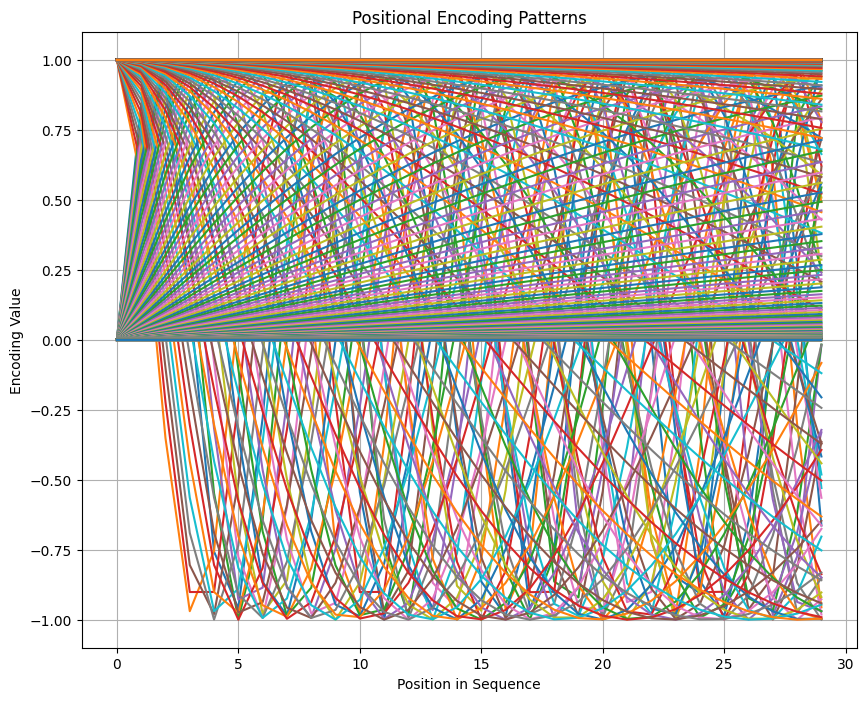

In [24]:
# KEN ADDED THIS TO VISUALIZE POSITIONAL ENCODINGS

import numpy as np
import matplotlib.pyplot as plt

def get_positional_encoding(max_seq_length, d_model):
    """Generate sinusoidal positional encodings."""
    positional_encoding = np.zeros((max_seq_length, d_model))
    for pos in range(max_seq_length):
        for i in range(0, d_model, 2):
            positional_encoding[pos, i] = np.sin(pos / (10000 ** ((2 * i)/d_model)))
            positional_encoding[pos, i + 1] = np.cos(pos / (10000 ** ((2 * (i + 1))/d_model)))
    return positional_encoding

# Generate positional encodings
max_seq_length = 30  # For example
d_model = 512
pos_encoding = get_positional_encoding(max_seq_length, d_model)

# Plot some dimensions
plt.figure(figsize=(10, 8))
for i in range(min(d_model, 512)):  # Plotting first 10 dimensions
    plt.plot(pos_encoding[:, i], label=f'Dimension {i+1}')

plt.title('Positional Encoding Patterns')
plt.xlabel('Position in Sequence')
plt.ylabel('Encoding Value')
#plt.legend()
plt.grid(True)
plt.show()
